# 使用 Kaggle 網站的 OnlineRetail 資料集，進行顧客生命週期價值（CLV）計算
三重點：<br>
一、問題定義：界定問題範圍、主要分析目的、欲尋找答案<br>
二、資料清整：根據所界定問題，有邏輯的清整資料<br>
三、計算 CLV：根據需要，求得所需的 CLV<br>

### 一、問題定義
1. 主要目的是練習計算 CLV。算法有：簡單的個別客戶 x 群體流失率價值計算，也有整群客戶以群體模型預測的方式計算，或個別客戶個別預測（？）。此次使用第一種算法。<br>
2. 為求取 CLV，須至少有客戶 ID、每次客戶交易金額、每次交易日期三類資料。<br>
3. 透過在網路上尋找，找到 Kaggle 上面的 [Online Retail 資料集](https://www.kaggle.com/vijayuv/onlineretail)，包含可產出前述三類資料之資訊。此資料集為英國某零售公司之交易資料，除所需資料外，尚包含發票號碼、存貨號碼、交易內容描述及交易國家等四資料，資料期間為 8 個月，從 2010/10/01 至 2011/12/09，共 541,908 筆資料。

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df_onliret = pd.read_csv('OnlineRetail.csv', encoding= 'unicode_escape', thousands = ',', parse_dates = ['InvoiceDate'])
df_onliret.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


檢視資料表頭，確認是 8 欄位資料沒錯。

### 二、資料清整

In [3]:
#檢視資料各屬性，看是否需調整或刪減；並可於刪減資料後、運算資料前，再次處理資料型態，因此時可能因為資料刪減，而使得資料內容更好被辨認是否為所需資料
df_onliret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


CustomerID 性質應該是屬於不可運算的 string，故進行題整：

In [4]:
df_onliret.CustomerID = df_onliret.CustomerID.astype(str)
df_onliret.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   541909 non-null  object        
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
#檢視期間內每月資料分布狀況，先決定是否要僅切割特定期間

#先求得每筆紀錄之交易金額
t_sales = df_onliret.Quantity * df_onliret.UnitPrice
df_onliret = df_onliret.assign(Sales = t_sales)
df_onliret

#增加交易日及月欄位
t_date = df_onliret.InvoiceDate.apply(lambda x: x.date())
t_m = df_onliret.InvoiceDate.apply(lambda x: x.month)
df_onliret = df_onliret.assign( Date = t_date)
df_onliret = df_onliret.assign( Month = t_m)
df_onliret

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Date,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,12
...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12-09,12
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60,2011-12-09,12
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09,12
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60,2011-12-09,12


<AxesSubplot:xlabel='Date'>

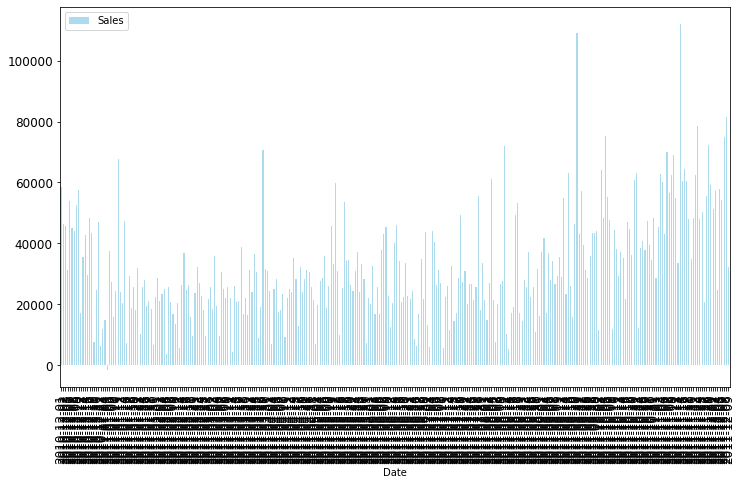

In [6]:
#了解期間內交易金額分布
day_sales = df_onliret[['Date','Sales']].groupby('Date').sum()
day_sales.plot(y = 'Sales', kind = 'bar', figsize = (12, 7), fontsize = 12, color = '#abdbec')

對於時間序列上之資料分布，應無特別要剃除者，故檢視最舊及最新日期，來決定是否調整：

In [7]:
print(df_onliret.Date.max())
df_onliret.Date.min()

2011-12-09


datetime.date(2010, 12, 1)

決定將時間所框在 2010/12/1 至 2011/11/30，讓資料剛好是一年，也方便客戶流失率及 CLV 之計算

In [8]:
#限縮資料期間範圍
import datetime

df_onliret['Date'].astype('datetime64[ns]')
df_onliret = df_onliret[df_onliret['Date'] < datetime.date(2011, 12, 1)]
df_onliret

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Date,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,12
...,...,...,...,...,...,...,...,...,...,...,...
516379,C579886,22197,POPCORN HOLDER,-1,2011-11-30 17:39:00,0.85,15676.0,United Kingdom,-0.85,2011-11-30,11
516380,C579886,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,-1,2011-11-30 17:39:00,3.29,15676.0,United Kingdom,-3.29,2011-11-30,11
516381,C579887,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,2011-11-30 17:42:00,1.25,16717.0,United Kingdom,-1.25,2011-11-30,11
516382,C579887,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2011-11-30 17:42:00,7.95,16717.0,United Kingdom,-7.95,2011-11-30,11


排除掉 3 萬多筆紀錄，剩下 51 萬 6,384 筆

             Sales
Month             
1       560000.260
2       498062.650
3       683267.080
4       493207.121
5       723333.510
6       691123.120
7       681300.111
8       682680.510
9      1019687.622
10     1070704.670
11     1461756.250
12      748957.020
            Sales
count       12.00
mean    776173.33
std     279180.26
min     493207.12
25%     650975.15
50%     687195.10
75%     816639.67
max    1461756.25


<AxesSubplot:xlabel='Month'>

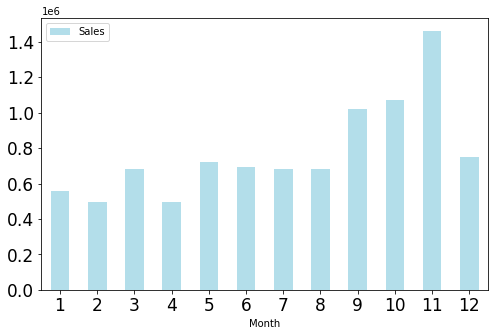

In [9]:
#了解每月銷售
m_sales = df_onliret[['Sales', 'Month']].groupby('Month').sum()
print(m_sales)
print(m_sales.describe().round(2))
m_sales.plot(kind = 'bar', figsize = (8, 5), fontsize = 17, rot = 0, color = '#b3deea')

In [10]:
(1282805.780-651766.25)/248831.66

2.536009806790663

可看到在 9 至 11 月時，該商家的銷售額較高，推測為聖誕假期因素，消費者或商家開始提前採購或舖貨所致。

In [11]:
#了解其銷售規模
ntd_er = 46.8236 #NTD exchange rate as of end of 2011
m_ntd = m_sales.Sales.mean() * ntd_er
print(f'平均每月銷售金額為 {m_sales.Sales.mean():.2f} 英鎊')
print(f'平均每月銷售金額為 {m_ntd:.0f} 台幣')
d_ntd = m_ntd / 30.5
print(f'平均每日銷售金額為 {d_ntd:.0f} 台幣')
d_n_orders = 516384/365
print(f'來自 {d_n_orders:.0f} 張訂單')
ntd_per_order = d_ntd / d_n_orders
print(f'平均每張訂單台幣 {ntd_per_order:.0f} 元')

平均每月銷售金額為 776173.33 英鎊
平均每月銷售金額為 36343229 台幣
平均每日銷售金額為 1191581 台幣
來自 1415 張訂單
平均每張訂單台幣 842 元


每月銷售額平均為 77 萬英鎊，約台幣 3634 萬；平均每日營業額 119 萬台幣，來自 1,415 張訂單，每張訂單平均金額為 842 元。判斷規模中大型廠商。

In [12]:
#留下需要的欄位即可：#0,3,4,5,6，可使用 7 來檢視是否需進一步鎖定特定國家的客戶群進行計算（假設流失狀況會因國家而不同）
df_onliret.Country.describe()

count             516384
unique                38
top       United Kingdom
freq              471552
Name: Country, dtype: object

發現顧客來自於 38 個國家，進一步檢視資料分佈，看是否選擇特定國家就好？

In [13]:
b = df_onliret.Country.value_counts()
b

United Kingdom          471552
Germany                   9155
France                    8218
EIRE                      7861
Spain                     2462
Netherlands               2285
Switzerland               2002
Belgium                   1971
Portugal                  1417
Australia                 1259
Norway                    1013
Italy                      795
Channel Islands            752
Finland                    681
Cyprus                     618
Sweden                     460
Unspecified                446
Austria                    394
Denmark                    378
Japan                      350
Poland                     341
Israel                     297
Hong Kong                  288
USA                        248
Singapore                  229
Iceland                    171
Canada                     151
Malta                      122
Greece                     110
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

求得第一名國家為 UK，進一步了解占比，已更確認資料集中狀況：

In [14]:
for i in b:
    c = i / len(df_onliret)
    print(f'{c:.2f}')

0.91
0.02
0.02
0.02
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00
0.00


UK 占比 91%，在假設不同國家可能有不同購物習性，而有不同流失率的狀況下，決定此次僅使用最大宗的 UK 資料，故刪除其他資料

In [15]:
df_onliret = df_onliret[df_onliret.Country == 'United Kingdom']
df_onliret

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Date,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,12
...,...,...,...,...,...,...,...,...,...,...,...
516379,C579886,22197,POPCORN HOLDER,-1,2011-11-30 17:39:00,0.85,15676.0,United Kingdom,-0.85,2011-11-30,11
516380,C579886,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,-1,2011-11-30 17:39:00,3.29,15676.0,United Kingdom,-3.29,2011-11-30,11
516381,C579887,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,2011-11-30 17:42:00,1.25,16717.0,United Kingdom,-1.25,2011-11-30,11
516382,C579887,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2011-11-30 17:42:00,7.95,16717.0,United Kingdom,-7.95,2011-11-30,11


驗證：刪除後列數等於前面計算出來的 UK 資料列數，故並未出現前端資料輸入字串多帶空格等問題

In [16]:
#檢視其他欄位是否存在異常資料
df_onliret.describe().round()

,Quantity,UnitPrice,Sales,Month
count,471552.0,471552.0,471552.0,471552.0
mean,9.0,4.0,17.0,7.0
std,163.0,97.0,205.0,3.0
min,-74215.0,-11062.0,-77184.0,1.0
25%,1.0,1.0,3.0,4.0
50%,3.0,2.0,8.0,8.0
75%,10.0,4.0,17.0,11.0
max,74215.0,38970.0,77184.0,12.0


發現 Quantity、UniPrice 和 Sales 有負值，調閱資料了解詳情，是否可能為退貨等因素？

In [17]:
#依貨物負值數量大小看前 20 名，是否有異常
df_onliret[df_onliret['Quantity'] < 0]['Quantity'].value_counts().sort_index().head(20)  

-74215    1
-9600     2
-9360     1
-9058     1
-5368     1
-4830     1
-3667     1
-3167     1
-3114     1
-3100     1
-3000     1
-2880     1
-2834     1
-2618     1
-2600     1
-2472     1
-2376     1
-2003     1
-2000     1
-1930     1
Name: Quantity, dtype: int64

看似無異常

In [18]:
#依被退次數最多之貨物數量多寡檢視前 20 名，看是否有異常
df_onliret[df_onliret['Quantity'] < 0]['Quantity'].value_counts().sort_values(ascending = False).head(20)

-1      3536
-2      1137
-3       497
-12      427
-4       411
-6       396
-24      210
-5       196
-10      159
-8       151
-7        91
-48       77
-9        69
-36       57
-100      56
-20       55
-11       54
-30       47
-16       46
-18       45
Name: Quantity, dtype: int64

看似無異常

In [19]:
#依樣檢視 UnitPrice
df_onliret[df_onliret['UnitPrice'] <= 0]['UnitPrice'].value_counts().sort_index(ascending = True).head(20)  

-11062.06       2
 0.00        2443
Name: UnitPrice, dtype: int64

發現有負值和 0 二類資訊，預計檢視負值之資料列，而 0 之資料列則因數量眾多，判斷為正常狀況，擬不予特別檢視

In [20]:
#檢視 UnitPrice 負值所在整列資訊
df_onliret[df_onliret['UnitPrice'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Date,Month
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,nan,United Kingdom,-11062.06,2011-08-12,8
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,nan,United Kingdom,-11062.06,2011-08-12,8


發現是為了調整壞帳所入之交易紀錄，但可能為往年資料，所以未直接抵銷在資料集中的特定客戶交易資料，故也無對應 CumstomerID。判斷與欲使用資料無關連，故予以刪除：

In [21]:
df_onliret = df_onliret[df_onliret['UnitPrice'] >= 0]
df_onliret

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Date,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,12
...,...,...,...,...,...,...,...,...,...,...,...
516379,C579886,22197,POPCORN HOLDER,-1,2011-11-30 17:39:00,0.85,15676.0,United Kingdom,-0.85,2011-11-30,11
516380,C579886,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,-1,2011-11-30 17:39:00,3.29,15676.0,United Kingdom,-3.29,2011-11-30,11
516381,C579887,84946,ANTIQUE SILVER T-LIGHT GLASS,-1,2011-11-30 17:42:00,1.25,16717.0,United Kingdom,-1.25,2011-11-30,11
516382,C579887,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2011-11-30 17:42:00,7.95,16717.0,United Kingdom,-7.95,2011-11-30,11


In [22]:
#檢視 Sales 負值所在整列資訊
df_onliret.sort_values(by = 'Sales', ascending = True).head(30)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Date,Month
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,-77183.60,2011-01-18,1
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom,-38970.00,2011-06-10,6
43702,C540117,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:55:00,16888.02,nan,United Kingdom,-16888.02,2011-01-05,1
43703,C540118,AMAZONFEE,AMAZON FEE,-1,2011-01-05 09:57:00,16453.71,nan,United Kingdom,-16453.71,2011-01-05,1
16356,C537651,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:49:00,13541.33,nan,United Kingdom,-13541.33,2010-12-07,12
15016,C537630,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:04:00,13541.33,nan,United Kingdom,-13541.33,2010-12-07,12
16232,C537644,AMAZONFEE,AMAZON FEE,-1,2010-12-07 15:34:00,13474.79,nan,United Kingdom,-13474.79,2010-12-07,12
446533,C574902,AMAZONFEE,AMAZON FEE,-1,2011-11-07 15:21:00,8286.22,nan,United Kingdom,-8286.22,2011-11-07,11
173277,C551685,POST,POSTAGE,-1,2011-05-03 12:51:00,8142.75,16029.0,United Kingdom,-8142.75,2011-05-03,5
342635,C566899,AMAZONFEE,AMAZON FEE,-1,2011-09-15 13:53:00,7427.97,nan,United Kingdom,-7427.97,2011-09-15,9


發現包含 amazon 交易費、郵資、調整壞帳的紀錄；屬於一般營運中會出現之情形，故不予調整 Sales

了解 Amazon Fee 類型以外，是否還有其他大筆負向 Sales：

In [23]:
df_onliret[df_onliret['StockCode'] != 'AMAZONFEE'].sort_values(by = 'Sales', ascending = True).head(30)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Date,Month
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,-77183.60,2011-01-18,1
222681,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,15098.0,United Kingdom,-38970.00,2011-06-10,6
173277,C551685,POST,POSTAGE,-1,2011-05-03 12:51:00,8142.75,16029.0,United Kingdom,-8142.75,2011-05-03,5
173391,C551699,M,Manual,-1,2011-05-03 14:12:00,6930.00,16029.0,United Kingdom,-6930.00,2011-05-03,5
160145,C550456,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,-3114,2011-04-18 13:08:00,2.10,15749.0,United Kingdom,-6539.40,2011-04-18,4
160143,C550456,85123A,WHITE HANGING HEART T-LIGHT HOLDER,-1930,2011-04-18 13:08:00,2.55,15749.0,United Kingdom,-4921.50,2011-04-18,4
160141,C550456,48185,DOORMAT FAIRY CAKE,-670,2011-04-18 13:08:00,6.75,15749.0,United Kingdom,-4522.50,2011-04-18,4
268027,C560372,M,Manual,-1,2011-07-18 12:26:00,4287.63,17448.0,United Kingdom,-4287.63,2011-07-18,7
349750,C567527,23113,PANTRY CHOPPING BOARD,-756,2011-09-21 09:16:00,5.06,17450.0,United Kingdom,-3825.36,2011-09-21,9
160144,C550456,21175,GIN + TONIC DIET METAL SIGN,-2000,2011-04-18 13:08:00,1.85,15749.0,United Kingdom,-3700.00,2011-04-18,4


推測其他項目應屬於取消訂單，所以負向註記了金額

### 3. 計算 CLV

In [24]:
#依照客戶 ID 做 groupby
df_gby = df_onliret.groupby('CustomerID').agg({'InvoiceDate': lambda date: (max(date) - min(date)).days,
                                               'InvoiceNo': lambda num: len(num),
                                               'Quantity': lambda quant: sum(quant),
                                               'Sales': lambda Total_Purchase: sum(Total_Purchase)})
df_gby 

,InvoiceDate,InvoiceNo,Quantity,Sales
CustomerID,,,,
12346.0,0,2,0,0.00
12747.0,347,96,1153,3757.51
12748.0,363,4336,23515,28001.83
12749.0,190,192,1195,3105.14
12820.0,282,47,607,731.99
...,...,...,...,...
18281.0,0,7,54,80.82
18282.0,4,8,70,98.76
18283.0,327,706,1255,1886.88


In [25]:
#因 Groupby 後有針對欄位重新計算，故根據各欄性質重新命名，以幫助解讀
df_gby.columns = ['Num_Days', 'Num_Transactions', 'Num_Units', 'Total_Purchase']
df_gby

,Num_Days,Num_Transactions,Num_Units,Total_Purchase
CustomerID,,,,
12346.0,0,2,0,0.00
12747.0,347,96,1153,3757.51
12748.0,363,4336,23515,28001.83
12749.0,190,192,1195,3105.14
12820.0,282,47,607,731.99
...,...,...,...,...
18281.0,0,7,54,80.82
18282.0,4,8,70,98.76
18283.0,327,706,1255,1886.88


In [26]:
#刪除客戶 ID 無資料的列
df_gby = df_gby[0:-1]
df_gby

,Num_Days,Num_Transactions,Num_Units,Total_Purchase
CustomerID,,,,
12346.0,0,2,0,0.00
12747.0,347,96,1153,3757.51
12748.0,363,4336,23515,28001.83
12749.0,190,192,1195,3105.14
12820.0,282,47,607,731.99
...,...,...,...,...
18280.0,0,10,45,180.60
18281.0,0,7,54,80.82
18282.0,4,8,70,98.76


In [27]:
# 了解顧客採買金額分布
df_gby.describe().round(2)

,Num_Days,Num_Transactions,Num_Units,Total_Purchase
count,3916.00,3916.00,3916.00,3916.00
mean,128.10,88.30,978.28,1652.18
std,129.61,208.74,3069.47,6305.04
min,0.00,1.00,-303.00,-4287.63
25%,0.00,16.00,145.00,277.40
50%,89.50,40.00,344.00,611.94
75%,250.00,98.00,887.25,1483.66
max,364.00,7512.00,68309.00,244952.95


發現有負值的總購買金額，需近一步檢視：

In [28]:
tp_minus = df_gby[df_gby['Total_Purchase']<0]
tp_minus.round()

,Num_Days,Num_Transactions,Num_Units,Total_Purchase
CustomerID,,,,
12870.0,0,2,-2,-15.0
12943.0,0,1,-1,-4.0
13154.0,0,1,-1,-612.0
13672.0,32,16,-1,-71.0
13693.0,0,4,-6,-32.0
13829.0,0,1,-12,-102.0
13958.0,0,5,-23,-102.0
14119.0,0,1,-2,-20.0
14213.0,0,5,-244,-1192.0


       Num_Days  Num_Transactions  Num_Units  Total_Purchase
count   3878.00           3878.00    3878.00         3878.00
mean     129.06             89.11     988.24         1671.43
std      129.72            209.59    3082.80         6332.41
min        0.00              1.00    -189.00            0.00
25%        0.00             17.00     149.00          287.12
50%       91.50             41.00     351.00          621.67
75%      250.00             99.00     892.75         1489.08
max      364.00           7512.00   68309.00       244952.95


<AxesSubplot:ylabel='Frequency'>

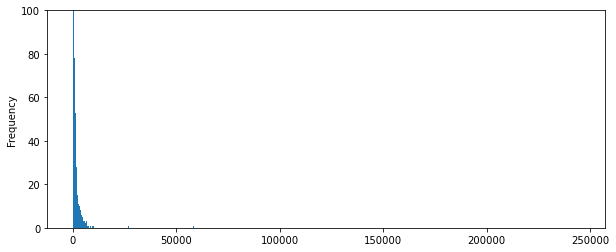

In [29]:
#不確定總購買金額為何會有負值，先予以刪除，以免產生不合理之負值 CLV
df_gby = df_gby[df_gby['Total_Purchase'] >= 0]
print(df_gby.describe().round(2))
df_gby.Total_Purchase.plot(kind = 'hist', bins = len(df_gby), ylim = (0, 100), figsize = (10, 4))

顯示 UK 顧客的購買狀況分布為非常極端的右偏分配，故以購買金額中位數 622 描述資料分布為佳。

In [30]:
621.67 * ntd_er

29108.827412

2.0     444
3.0     418
1.0     351
4.0     310
5.0     220
6.0     215
7.0     187
9.0     126
8.0     125
10.0    108
11.0    108
13.0     82
14.0     78
12.0     66
15.0     64
16.0     59
17.0     53
18.0     52
0.0      47
20.0     42
Name: Total_Purchase, dtype: int64
2.0     11.449201
3.0     10.778752
1.0      9.051057
4.0      7.993811
5.0      5.673027
6.0      5.544095
7.0      4.822073
9.0      3.249097
8.0      3.223311
10.0     2.784941
11.0     2.784941
13.0     2.114492
14.0     2.011346
12.0     1.701908
15.0     1.650335
16.0     1.521403
17.0     1.366684
18.0     1.340897
0.0      1.211965
20.0     1.083032
Name: Total_Purchase, dtype: float64
8.0     113
5.0     109
14.0    108
15.0    103
7.0     101
10.0    101
6.0      92
9.0      85
16.0     82
12.0     80
18.0     78
11.0     76
17.0     75
13.0     71
19.0     63
4.0      59
31.0     58
20.0     57
23.0     56
28.0     55
Name: Total_Purchase, dtype: int64


<AxesSubplot:ylabel='Frequency'>

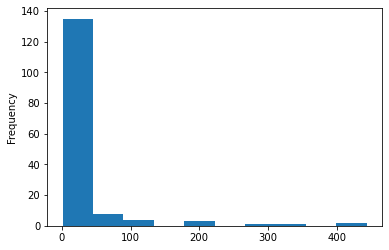

In [31]:
#了解多數顧客採購金額範圍

#每 100 英鎊為單位，計算分布
p_range = df_gby.Total_Purchase / 100
dis = p_range.round(0).value_counts()
dis_per = dis / sum(dis) *100
print(dis.head(20))
print(dis_per.head(20))

#了解折合台幣價位，並以 1000 為單位
prn = df_gby.Total_Purchase * ntd_er / 1000
print(prn.round(0).value_counts().head(20))

dis.plot(kind = 'hist')

In [32]:
#計算客戶流失率 Churn Rate
churn_rate = len(df_gby[df_gby['Num_Transactions'] == 1]) / len(df_gby)
churn_rate

0.014956162970603403

In [33]:
#亦即客戶存區期間為
print(1/churn_rate)
12*(1/churn_rate -66)

66.86206896551724


10.344827586206861

客戶流失率低，故反推客戶存續期間約為 66 年又 10 個月

In [34]:
#假設商品平均毛利率為 5%，故計算 CLV 為
CLV = df_gby['Total_Purchase'] * 0.05 / churn_rate
CLV = CLV.round(2)
CLV

CustomerID
12346.0        0.00
12747.0    12561.74
12748.0    93613.01
12749.0    10380.80
12820.0     2447.12
             ...   
18280.0      603.76
18281.0      270.19
18282.0      330.16
18283.0     6308.04
18287.0     6142.22
Name: Total_Purchase, Length: 3878, dtype: float64

In [35]:
#放入資料表中
df_CLV = df_gby.assign( CLV = CLV)
df_CLV.sort_values(by = 'CLV', ascending = False).head(10)  #檢視前 10 大客戶 CLV

,Num_Days,Num_Transactions,Num_Units,Total_Purchase,CLV
CustomerID,,,,,
18102.0,355,410,61424,244952.95,818903.05
17450.0,357,346,68309,185919.77,621549.02
17511.0,357,1003,55797,80746.06,269942.43
16684.0,346,252,44658,60490.10,202224.66
13694.0,348,562,59363,59521.94,198988.00
15311.0,363,2419,37221,58352.77,195079.35
13089.0,358,1768,28499,52704.26,176195.79
16029.0,335,274,32148,50992.61,170473.57
14298.0,329,1623,57983,50889.70,170129.53


In [36]:
df_CLV.CLV.describe().round(2) #plot(kind = 'hist', bins = 3016, ylim = (0, 220), figsize = (20, 8))

count      3878.00
mean       5587.77
std       21169.92
min           0.00
25%         959.86
50%        2078.31
75%        4978.13
max      818903.05
Name: CLV, dtype: float64

<AxesSubplot:ylabel='Frequency'>

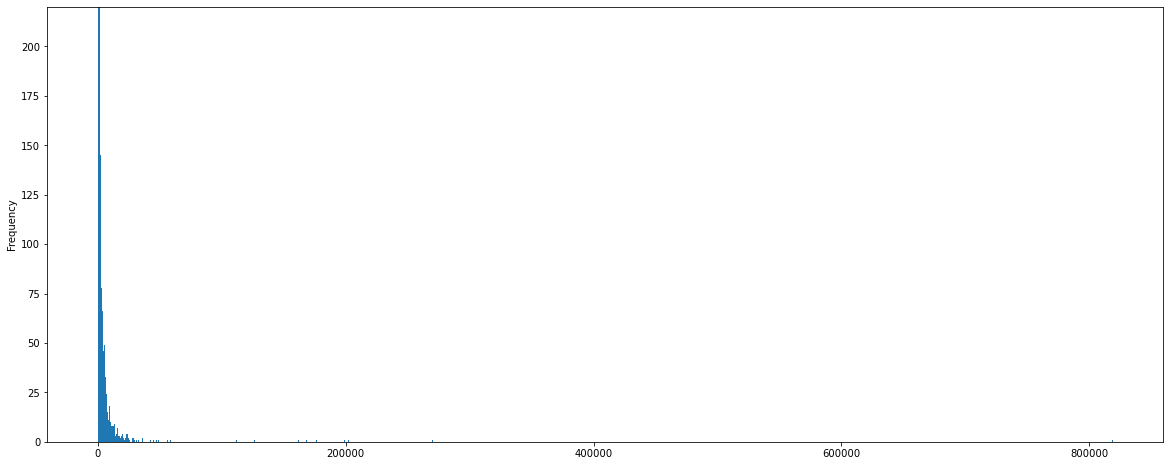

In [37]:
df_CLV.CLV.plot(kind = 'hist', bins = len(df_CLV), ylim = (0, 220), figsize = (20, 8))

In [38]:
t1 = df_CLV.CLV / 1000
t2 = t1.round(0).value_counts().head(30)
print(t2)
t3 = t2 / len(df_CLV) * 100
print(t3.round(2))

1.0     1172
2.0      620
0.0      395
3.0      358
4.0      259
5.0      201
6.0      146
7.0      118
9.0       80
8.0       76
11.0      56
10.0      54
12.0      42
13.0      32
16.0      22
14.0      21
15.0      20
17.0      16
20.0      15
19.0      15
18.0      14
23.0      12
26.0      11
22.0       9
24.0       8
34.0       6
21.0       6
35.0       6
25.0       5
28.0       5
Name: CLV, dtype: int64
1.0     30.22
2.0     15.99
0.0     10.19
3.0      9.23
4.0      6.68
5.0      5.18
6.0      3.76
7.0      3.04
9.0      2.06
8.0      1.96
11.0     1.44
10.0     1.39
12.0     1.08
13.0     0.83
16.0     0.57
14.0     0.54
15.0     0.52
17.0     0.41
20.0     0.39
19.0     0.39
18.0     0.36
23.0     0.31
26.0     0.28
22.0     0.23
24.0     0.21
34.0     0.15
21.0     0.15
35.0     0.15
25.0     0.13
28.0     0.13
Name: CLV, dtype: float64
